In [1]:
import pandas as pd
import re
import unidecode
import demoji
import nltk
from nltk.corpus import stopwords
from spacy.lang.pt.stop_words import STOP_WORDS
import spacy
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import tokenize
import nltk

%matplotlib inline

nlp = spacy.load("pt")
nlp.Defaults.stop_words |= {"gt", "&gt", "to","uol","mi","budddhetg","the", "ne", "vou", "ta", "via","ex", "pq", "vc","aa","pra","to", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"}

In [2]:
palavras_irrelevantes = set(stopwords.words('portuguese') + list(punctuation))

In [3]:
data = pd.read_csv("data/dataTweeter.csv", sep=";", encoding='utf8')

In [4]:
data.head()

,ID,USER,POST
0,1376863023600599043,g1,Veja a previsão de entrega de vacinas da Fiocr...
1,1376859250056519687,g1,Presidente trocou comandos de Relações Exterio...
2,1376855473828290562,g1,Vítima era obrigada a realizar serviços domést...
3,1376851704335978500,g1,Os dois defendiam a vacinação nas redes sociai...
4,1376847923758108672,g1,Leia os bastidores no blog do @gcamarotti http...


In [5]:
def cleanText(tweet):
    if "|" in tweet:
        tweet = tweet.split("|")[1]
    
    tweet = ' '.join(re.sub(r"http\S+", "", tweet).split())
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([0-9])", " ", tweet).split())
    tweet = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split())
    tweet = ' '.join(re.sub("[\_\|\.\,\"\'\!\?\:\;\$\-\(\)\=]", " ", tweet).split())
    tweet = tweet.lower()
    
    le = list(demoji.findall(tweet))
    for i in le:
        tweet = tweet.replace(i, "")
    
    if tweet.startswith('rt '):
        tweet = tweet.replace("rt ", "")
    
    lNewTweet = []
    for i in tweet.split(" "):
        if i not in palavras_irrelevantes and i not in STOP_WORDS:
            lNewTweet.append(i)
    
    newTweet = " ".join(lNewTweet)
        
    return unidecode.unidecode(newTweet.replace(" rt ", ""))

In [6]:
data["tweet_text_clean"] = data.POST.apply(cleanText)

In [7]:
data.head()

,ID,USER,POST,tweet_text_clean
0,1376863023600599043,g1,Veja a previsão de entrega de vacinas da Fiocr...,previsao entrega vacinas fiocruz butantan
1,1376859250056519687,g1,Presidente trocou comandos de Relações Exterio...,presidente trocou comandos relacoes exteriores...
2,1376855473828290562,g1,Vítima era obrigada a realizar serviços domést...,vitima realizar servicos domesticos remuneraca...
3,1376851704335978500,g1,Os dois defendiam a vacinação nas redes sociai...,defendiam vacinacao redes sociais
4,1376847923758108672,g1,Leia os bastidores no blog do @gcamarotti http...,leia bastidores blog


In [8]:
token_ = [doc.split(" ") for doc in data["tweet_text_clean"].tolist()]
token_3 = []
token_2 = [[token_3.append(y) for y in x] for x in token_]

frequencia = nltk.FreqDist(token_3)
freqmc = frequencia.most_common(10000)
# freqmc

In [9]:
import gensim
import sys


from gensim.models.phrases import Phraser

bigram = gensim.models.Phrases(token_, min_count=1, threshold=0.1) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[token_], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# [bigram_mod[doc] for doc in token_]
# for doc in token_:
#     print(doc)
#     print("\n")

# bigram_mod[['acesse', 'mw', 'fique', 'informado', 'hks', 'mkgh']]
l = [trigram_mod[bigram_mod[doc]] for doc in token_]
# l
# for doc in token_:
#     print(doc)
# print(trigram_mod[bigram_mod[doc]])
#     break


In [10]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(l)
corpus = [id2word.doc2bow(text) for text in l]


In [11]:
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=4, 
#                                        random_state=100,
#                                        chunksize=100,
#                                        passes=10,
#                                        per_word_topics=True)

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=28, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.01)

In [12]:
from pprint import pprint# Print the Keyword in the 10 topics
# doc_lda = lda_model[corpus]
# print(dir(doc_lda))
# print(doc_lda.corpus)
# pprint(lda_model.print_topics())
# pprint(dir(lda_model))
# pprint(lda_model.get_topics())
# print(lda_model.show_topic(2))
lt = []
for i, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    lt.append(row[0][0])

# print(lt)
contents = pd.Series(lt, name="topic")
data_new = pd.concat([data, contents], axis=1)

In [13]:
# data_new.head()
data_new[data_new["topic"] == 1].sample(10)["tweet_text_clean"].tolist()

['arqueologos encontram mascara ouro milenar durante escavacoes china',
 'vacinas levou serie protestos pais crise resultou demissoes ministros pedido saida presidente',
 'guarda arma choque comerciante protesto abertura comercio pessoa imobilizada arma choque durante manifestacao cidade hortolandia sp protestos pediam reabertura comercio contrariando medidas enfrentamento pandemia',
 'mae padrasto presos suspeita matar rapaz anos sp',
 'sofrimento conheca pequenas acoes aliviam dor pandemia',
 'achei certo festa comemorar vida milhoes pessoas morrem',
 'comite ve colapso sp propoe ampliar fase emergencial dias',
 'ibge proposta original encaminhada congresso nacional ano passado previa bilhoes',
 'cadeirante sofre infarto morre atirar policiais homem morreu cidade barao melgaco mato grosso sofrer infarto conflito policiais militares videos aparece atirando agentes passar',
 'ala stf decisao lula mantida ministros tema nebuloso gerar discussao plaenario']

In [14]:
# coherence_model_lda = CoherenceModel(model=lda_model, texts=l, dictionary=id2word, coherence='c_v')
# coherence_model_lda.get_coherence()
# Encontrar qual o principal tópico em cada tweet

# def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=l):
#     # Output
#     sent_topics_df = pd.DataFrame()# Seleciona o principal tópico de cada tweet
#     for i, row in enumerate(ldamodel[corpus]):
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => mostra o principal tópico
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']# Inclui o texto original no final do DataFrame
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)# roda a função de calcular os principais tópicos de cada tweet

# df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=l)# Formata o DataFrame
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']# Group top 5 sentences under each topic
# sent_topics_sorteddf_mallet = pd.DataFrame()
# sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')
# for i, grp in sent_topics_outdf_grpd:
#     sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
#                                              grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
#                                             axis=0)# Reset Index    
# sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)# Format
# sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]# Show
# sent_topics_sorteddf_mallet

In [15]:
# sent_topics_sorteddf_mallet["Tweet"][0]

100%|██████████| 14/14 [01:04<00:00,  4.64s/it]


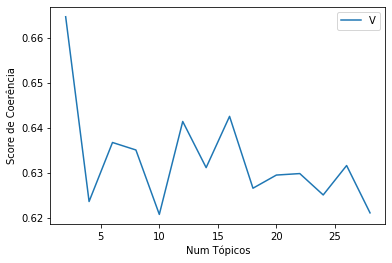

A quantidade de tópicos = 2  tem um valor de coerência de  0.6646
A quantidade de tópicos = 4  tem um valor de coerência de  0.6236
A quantidade de tópicos = 6  tem um valor de coerência de  0.6367
A quantidade de tópicos = 8  tem um valor de coerência de  0.6351
A quantidade de tópicos = 10  tem um valor de coerência de  0.6208
A quantidade de tópicos = 12  tem um valor de coerência de  0.6414
A quantidade de tópicos = 14  tem um valor de coerência de  0.6312
A quantidade de tópicos = 16  tem um valor de coerência de  0.6425
A quantidade de tópicos = 18  tem um valor de coerência de  0.6266
A quantidade de tópicos = 20  tem um valor de coerência de  0.6295
A quantidade de tópicos = 22  tem um valor de coerência de  0.6298
A quantidade de tópicos = 24  tem um valor de coerência de  0.6251
A quantidade de tópicos = 26  tem um valor de coerência de  0.6316
A quantidade de tópicos = 28  tem um valor de coerência de  0.6211


In [16]:
from tqdm import tqdm
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        
        model = gensim.models.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values# Colocando parametros na função
    

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=l, start=2, limit=30, step=2)
# Mostrando visualmente a quantidade de tópicos
limit=30; start=2; step=2;
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

In [17]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=l, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [18]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [3:02:39<00:00, 20.30s/it]  


In [19]:
pd.DataFrame(model_results).to_csv('/home/leo/lda_tuning_results.csv', index=False)